### 填补缺失值
- sklearn.impute.SimpleImputer可以导入平均值、中值等常用的数据值

这个实例中使用均值、0、随机森林回归来填补缺失值（特征矩阵中的），对比四种情况（完整情况）

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

In [18]:
boston = load_boston()
boston.data.shape
type(boston.data)

numpy.ndarray

In [19]:
# 将boston完整的部分先取出
X_full, Y_full = boston.data, boston.target
n_samples = X_full.shape[0]
n_features = X_full.shape[1]

In [20]:
# 确定放入缺失值的比例
rng = np.random.RandomState(0) # 随机种子 确定一种随机模式，其实是代替了所有random_state
missing_rate = 0.5
n_missing_samples = int(np.floor(n_features *n_samples*missing_rate))
# np.floor向下取整，返回.0浮点数

In [21]:
# 将缺失值随机分布在各行各列
# 思路 :n_missing_samples个0-506的行索引和0-13之间的列索引
# randint(lo,hi,n)[lo,hi]之间取出n个整数
missing_samples = rng.randint(0, n_samples, n_missing_samples)
missing_features = rng.randint(0, n_features, n_missing_samples)

# 若没有那么多的比例，如果需要的数据量小于样本量506，可以采用
# np.random.choice()会抽取不重复的随机数，可以帮助数据更加分散
# missing_samples = rng.choice(n_samples, n_missing_samples, replace=False)

In [22]:
X_missing = X_full.copy()
Y_missing = Y_full.copy()

X_missing[missing_samples,missing_features] = np.nan
#Y_missing[missing_samples] = np.nan标签不能空，
X_missing

array([[       nan,        nan, 2.3100e+00, ...,        nan,        nan,
               nan],
       [2.7310e-02, 0.0000e+00,        nan, ..., 1.7800e+01,        nan,
        9.1400e+00],
       [2.7290e-02,        nan, 7.0700e+00, ...,        nan, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [       nan,        nan,        nan, ..., 2.1000e+01,        nan,
        6.4800e+00],
       [4.7410e-02,        nan,        nan, ...,        nan, 3.9690e+02,
        7.8800e+00]])

In [23]:
X_missing = pd.DataFrame(X_missing)
# numpy对矩阵的运算速度快，但对索引的操作还是pandas好用
# X_missing

In [20]:
# 使用均值进行填补
# SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean') # 实例化
X_missing_mean = imp_mean.fit_transform(X_missing) # fit+predict>>特殊接口 fit_tranform：将缺失值填充并返回

In [22]:
# 看看是否填补完毕
pd.DataFrame(X_missing_mean).isnull().sum() 
# X_missing_mean为array， DataFrame才可以调用isnull()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

In [8]:
# 使用0进行填补
# SimpleImputer

imp_0 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0) # 实例化
X_missing_0 = imp_0.fit_transform(X_missing) # fit+predict>>特殊接口 fit_tranform：将缺失值填充并返回

In [32]:
# 使用随机森林填补缺失值
# 填补原理：
# - 回归：从特征矩阵中学习模型求解连续型标签y的过程
# - 标签和特征可以互相转换
# 这种做法适用于： 某一特征大量缺失，其他特征很完整的情况
# >1个特征大量缺失: 遍历所有特征，从缺失最少的特征开始填补（因为缺失最少的特征需要准确信息最少）

X_missing_reg = X_missing.copy()
sortindex = np.argsort(X_missing_reg.isnull().sum(axis=0)).values
# argsort对索引返回
ind = [3,5,4]
# type(ind[0])
id1 = np.array([3,5,4])
type(id1[0])

numpy.int64

In [26]:
X_missing_reg.loc[X_missing_reg.loc[:,3].isnull(),3] = np.array(range(196))

In [27]:
X_missing_reg[3]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
       ...  
501    193.0
502      0.0
503    194.0
504    195.0
505      0.0
Name: 3, Length: 506, dtype: float64

In [11]:
for i in sortindex:
    # 构建新的特征矩阵
    df = X_missing_reg
    fillc = df.iloc[:,i]
    df = pd.concat((df.iloc[:,df.columns!=i], pd.DataFrame(Y_full)), axis=1)
    
    # 填补新的特征矩阵中的缺失值为0
    df_0 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0).fit_transform(df)
    
    # 训练集和测试集
    Ytrain = fillc[fillc.notnull()]
    Ytest = fillc[fillc.isnull()] # 需要索引值
    Xtrain = df_0[Ytrain.index,:]
    Xtest = df_0[Ytest.index,:]
    
    # 采用回归进行填充
    rfc = RandomForestRegressor(n_estimators=100)
    rfc = rfc.fit(Xtrain, Ytrain)
    Ypredict = rfc.predict(Xtest)
    
    # 将填充值返回到原始特征矩阵
    # 填充第i列的空值
    X_missing_reg.loc[X_missing_reg.loc[:,i].isnull(),i] = Ypredict

In [16]:
X_missing_reg.loc[X_missing_reg.loc[:,3].isnull(),3]
# .sum().values

Series([], Name: 3, dtype: float64)

In [13]:
X_missing_reg

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.189002,15.02,2.3100,0.00,0.447704,6.57500,65.200,4.090000,1.00,247.79,18.173,389.1798,7.6388
1,0.027310,0.00,5.9762,0.00,0.469000,6.42100,46.980,4.967100,2.00,242.00,17.800,391.0834,9.1400
2,0.027290,26.85,7.0700,0.00,0.442646,7.18500,29.636,4.967100,5.09,242.00,16.596,392.8300,4.0300
3,0.032370,0.00,4.4213,0.03,0.458000,7.08850,53.648,4.271524,3.98,222.00,18.700,394.6300,5.1041
4,0.055795,0.00,2.1800,0.00,0.458000,7.12826,54.200,4.743819,3.00,222.29,18.700,396.9000,6.0219
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.062630,0.00,11.9300,0.12,0.573000,6.59300,69.100,2.478600,1.00,273.00,21.000,391.9900,9.6700
502,0.045270,0.00,11.9300,0.00,0.573000,6.12000,79.776,2.287500,3.85,273.00,21.000,396.9000,9.0800
503,0.060760,0.00,11.9300,0.04,0.573540,6.69452,76.633,2.167500,1.00,273.00,21.000,396.9000,5.6400
504,0.065161,4.22,5.6905,0.11,0.473220,6.79400,38.053,5.154296,1.00,264.47,21.000,390.5357,6.4800


In [50]:
from sklearn.model_selection import cross_val_score
X = [X_full, X_missing_mean, X_missing_0, X_missing_reg]
mse = []
for x in X:
    rfc = RandomForestRegressor(n_estimators=100)
    scores = cross_val_score(rfc, x, Y_full, cv=5
                   ,scoring = 'neg_mean_squared_error').mean()
    mse.append(scores*(-1))

mse

[21.18148573589594, 42.6996749154339, 45.856943771092986, 15.915806521277418]

In [51]:
[*zip(['X_full', 'X_missing_mean', 'X_missing_0', 'X_missing_reg'],mse)]

[('X_full', 21.18148573589594),
 ('X_missing_mean', 42.6996749154339),
 ('X_missing_0', 45.856943771092986),
 ('X_missing_reg', 15.915806521277418)]

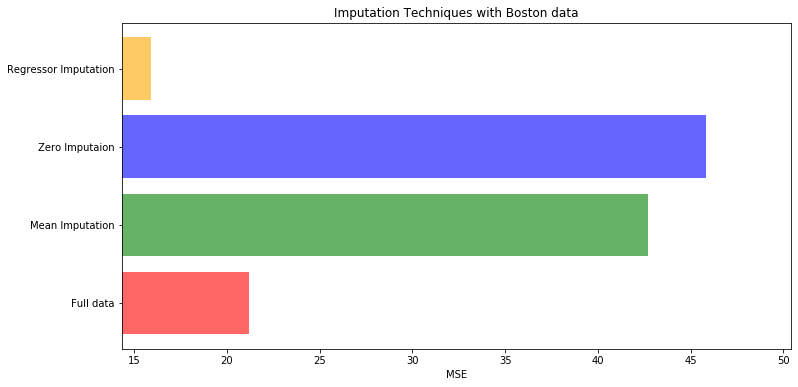

In [56]:
# 画图
x_labels = ['Full data',
            'Mean Imputation',
            'Zero Imputaion',
            'Regressor Imputation'
]

colors = ['r','g','b','orange']

plt.figure(figsize=(12,6))
ax = plt.subplot(111)

for i in np.arange(len(mse)):
    ax.barh(i,mse[i],color=colors[i],alpha = 0.6, align='center')
    
ax.set_title('Imputation Techniques with Boston data')
ax.set_xlim(left = np.min(mse)*0.9,right=np.max(mse)*1.1)
ax.set_yticks(np.arange(len(mse)))
ax.set_xlabel('MSE')
ax.set_yticklabels(x_labels)
plt.show()
